_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [140]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

In [212]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

In [142]:
df.sample(10)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2019-01-13,21800642,349,Stephen Curry,3,10,6,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,28,-191,207,1,DAL,GSW,Regular Season,5.0
2013-03-30,21201094,285,Stephen Curry,3,10,36,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,17,92,149,1,GSW,POR,Regular Season,9.0
2013-03-20,21201016,415,Stephen Curry,4,5,46,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,13,-101,91,1,SAS,GSW,Regular Season,-8.0
2009-12-14,20900345,69,Stephen Curry,1,5,43,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,21,-146,156,0,PHI,GSW,Regular Season,-4.0
2017-04-24,41600144,57,Stephen Curry,1,5,45,No Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,28,148,247,1,POR,GSW,Playoffs,20.0
2016-11-04,21600078,238,Stephen Curry,2,2,33,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,25,-170,194,0,LAL,GSW,Regular Season,-11.0
2014-12-13,21400340,547,Stephen Curry,4,1,39,Running Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,65,37,0,DAL,GSW,Regular Season,12.0
2010-02-27,20900877,217,Stephen Curry,2,2,41,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6,-5,61,0,GSW,DET,Regular Season,-8.0
2015-11-27,21500236,370,Stephen Curry,3,2,29,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,22,-227,-11,0,PHX,GSW,Regular Season,18.0


In [143]:
df.columns

Index(['game_id', 'game_event_id', 'player_name', 'period',
       'minutes_remaining', 'seconds_remaining', 'action_type', 'shot_type',
       'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance',
       'loc_x', 'loc_y', 'shot_made_flag', 'htm', 'vtm', 'season_type',
       'scoremargin_before_shot'],
      dtype='object')

In [144]:
df.isnull().sum()

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

*****Feature Engineering*****

In [145]:
# drop player_name since whole df is for curry's shots, game ID and Game event ID are just 
# unique identifiers which won't add much info and will increase computation time

df = df.drop(columns=['player_name','game_id','game_event_id'])

In [146]:
# Home team advantage feature addition
df['htm_adv'] = df['htm'].apply(lambda x: 1 if x == 'GSW' else 0)

In [147]:
#Seconds remaining in the period 
df['sec_rem_period'] = df['minutes_remaining']*60 + df['seconds_remaining'] 

In [148]:
#Seconds remaining in the game
df['sec_rem_game'] = df['sec_rem_period'] + (df['period'].apply(lambda x:(3*12*60) if x ==1 
                                                               else (2*12*60) if x ==2
                                                                else (12*60) if x ==3
                                                                else 0))

In [224]:
# # opponent

# team_finder = lambda x: 

# df['opponent'] = df['htm']
# df['opponent'] = df['htm'].apply(lambda x: df['vtm'] if x != 'GSW' else df['htm'] )

In [225]:
df.sample(10)

,game_date,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,...,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,htm_adv,sec_rem_period,sec_rem_game,opponent
8537,2016-03-03,4,2,16,Step Back Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,26,...,257,1,GSW,OKC,Regular Season,11.0,1,136,136,GSW
2235,2012-01-02,1,9,26,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,21,...,134,1,PHX,GSW,Regular Season,-1.0,0,566,2726,HOU
7352,2015-06-14,1,8,7,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,...,20,1,GSW,CLE,Playoffs,0.0,1,487,2647,GSW
6928,2015-04-11,3,0,46,Running Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,...,48,0,GSW,MIN,Regular Season,14.0,1,46,766,GSW
4550,2013-12-19,4,6,31,Pullup Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,26,...,254,0,GSW,SAS,Regular Season,0.0,1,391,391,GSW
4453,2013-12-09,4,0,21,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,...,9,1,CHA,GSW,Regular Season,-6.0,0,21,21,HOU
7632,2015-11-17,1,7,50,Running Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,...,18,1,GSW,TOR,Regular Season,3.0,1,470,2630,GSW
1528,2011-01-03,4,3,24,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,23,...,0,1,ORL,GSW,Regular Season,-19.0,0,204,204,HOU
12137,2018-05-28,1,7,57,Floating Jump shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,16,...,-16,0,HOU,GSW,Playoffs,-1.0,0,477,2637,HOU
2582,2012-11-09,3,10,28,Driving Finger Roll Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,...,17,1,LAL,GSW,Regular Season,-9.0,0,628,1348,HOU


***Train/Split***

In [150]:
df = df.reset_index()


In [151]:
df.head()

,game_date,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,htm_adv,sec_rem_period,sec_rem_game
0,2009-10-28,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0,1,685,2845
1,2009-10-28,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0,1,571,2731
2,2009-10-28,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0,1,362,2522
3,2009-10-28,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0,1,589,2029
4,2009-10-28,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0,1,139,1579


In [152]:
train = df[df['game_date'] < '2017-07-01']
val = df[(df['game_date'] >'2017-07-01') & (df['game_date'] < '2018-07-01')]
test = df[df['game_date'] > '2018-07-01']

In [153]:
train.shape, test.shape, val.shape

((11081, 20), (1709, 20), (1168, 20))

***baselines for classification***

In [154]:
train['shot_made_flag'].value_counts() 

0    5842
1    5239
Name: shot_made_flag, dtype: int64

In [155]:
y_pred = np.full_like(y_val, fill_value=train['shot_made_flag'].mean())

In [156]:
y_val = val['shot_made_flag']

In [157]:
baseline_accuracy = accuracy_score(y_val, y_pred)

In [158]:
print (baseline_accuracy)

0.5162671232876712


***Ordinal Encoding or One-Hot Encoding***

In [159]:
categorical_features = train.select_dtypes(exclude=[np.number]).columns.to_list()
numerical_features = train.select_dtypes(include=[np.number]).columns.to_list()

In [160]:
numerical_features = list(set(numerical_features) - set(['shot_made_flag']))

In [161]:
categorical_features = list(set(categorical_features) - set(['game_date']))

In [162]:
categorical_features

['shot_zone_area',
 'htm',
 'shot_zone_basic',
 'season_type',
 'shot_zone_range',
 'shot_type',
 'action_type',
 'vtm']

In [163]:
numerical_features

['shot_distance',
 'loc_y',
 'minutes_remaining',
 'period',
 'sec_rem_period',
 'loc_x',
 'sec_rem_game',
 'seconds_remaining',
 'htm_adv',
 'scoremargin_before_shot']

In [164]:
features = categorical_features + numerical_features 

In [165]:
target = ['shot_made_flag']

In [166]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [168]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ord', ce.OrdinalEncoder())]) 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('ord', ordinal_transformer, categorical_features)])

In [174]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=3,
                             criterion='gini', max_features='auto', oob_score=True,
                             random_state=5, n_jobs=-1)

In [175]:
classification = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rf', RandomForestClassifier(max_depth=15))])

In [184]:
classification.fit(X_train, y_train)

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [185]:
print("Training score: %.3f" % classification.score(X_train, y_train))

Training score: 0.871


***Validation Accuracy***

In [188]:
y_pred = classification.predict(X_val)
print("Validation score: %.3f" % accuracy_score(y_pred, y_val))

Validation score: 0.586


***Test Accuracy***

In [189]:
y_pred = classification.predict(X_test)
print("Test score: %.3f" % classification.score(X_test, y_test))

Test score: 0.624


***Feature Importances***

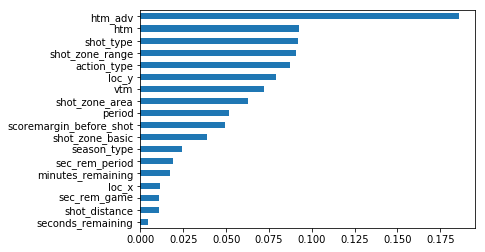

In [200]:
rf = classification.named_steps['rf']
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

***Accuracy , precision and recall***

In [206]:
print("Accuracy:", (85+36)/(85+36+8+58))

Accuracy: 0.6470588235294118


In [209]:
Precision = (36)/(36+58)
print("Precision:", (36)/(36+58))

Precision: 0.3829787234042553


In [210]:
Recall = (36)/(36+8)
print("Recall:", (36)/(36+8))

Recall: 0.8181818181818182


***F1 Score***

In [211]:
F1 = (2*(Precision*Recall))/(Precision+Recall)
print("F1 Score:", F1)

F1 Score: 0.5217391304347826


***Classification report*** 

In [214]:
y_pred = classification.predict(X_val)
print("Validation score: %.3f" % accuracy_score(y_pred, y_val))

Validation score: 0.586


In [215]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.64      0.62       603
           1       0.58      0.53      0.55       565

   micro avg       0.59      0.59      0.59      1168
   macro avg       0.59      0.58      0.58      1168
weighted avg       0.59      0.59      0.59      1168

